# ARIMA Example

An introduction to ARIMA forecasting with scalecast. The following topics are covered:  
1. Naive ARIMA Forecasting  
2. Using Exploratory Analysis to set ARIMA orders  
3. Using pmdarima to set ARIMA orders with an information criteria search  
4. Using scalecast to automatically set ARIMA orders with a grid search  
5. Plotting test-set predictions  
6. Plotting future forecasts  
7. Viewing ARIMA model summaries  

- data: https://www.kaggle.com/datasets/rakannimer/air-passengers
- blog post: https://towardsdatascience.com/forecast-with-arima-in-python-more-easily-with-scalecast-35125fc7dc2e

In [5]:
!pip install scalecast
!pip install pmdarima
import pandas as pd
import numpy as np
from scalecast.Forecaster import Forecaster
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(14,7)})

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 4.4 MB/s 
     |████████████████████████████████| 9.8 MB 50.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [6]:
df = pd.read_csv('AirPassengers.csv')
f = Forecaster(y=df['#Passengers'],current_dates=df['Month'])
f

Forecaster(
    DateStartActuals=1949-01-01T00:00:00.000000000
    DateEndActuals=1960-12-01T00:00:00.000000000
    Freq=MS
    N_actuals=144
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
)

## Naive Simple Approach

In [7]:
f.generate_future_dates(12)
f.set_test_length(.2)
f.set_estimator('arima')
f.manual_forecast(call_me='arima1')

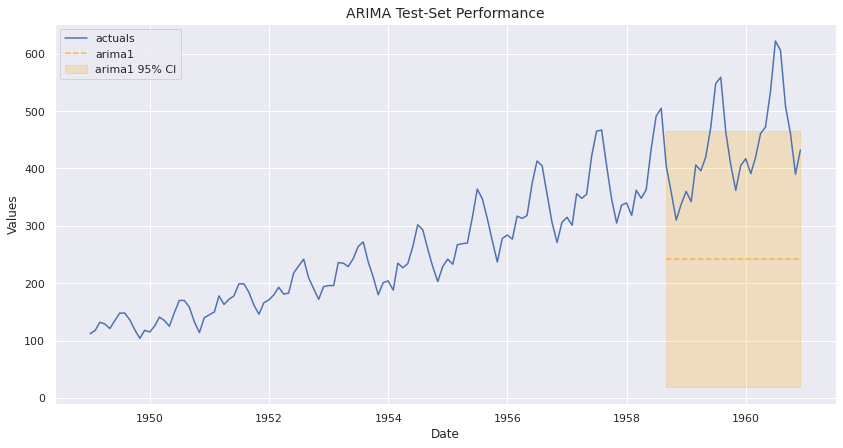

In [8]:
f.plot_test_set(ci=True)
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

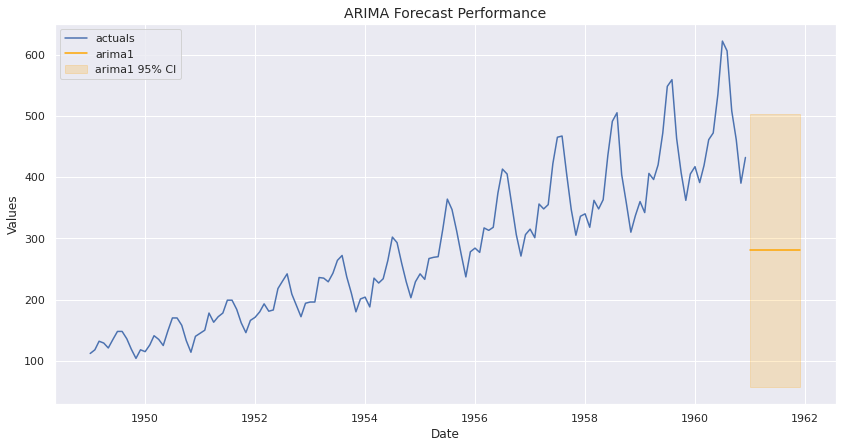

In [9]:
f.plot(ci=True)
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

## Human Interpreation Iterative Approach

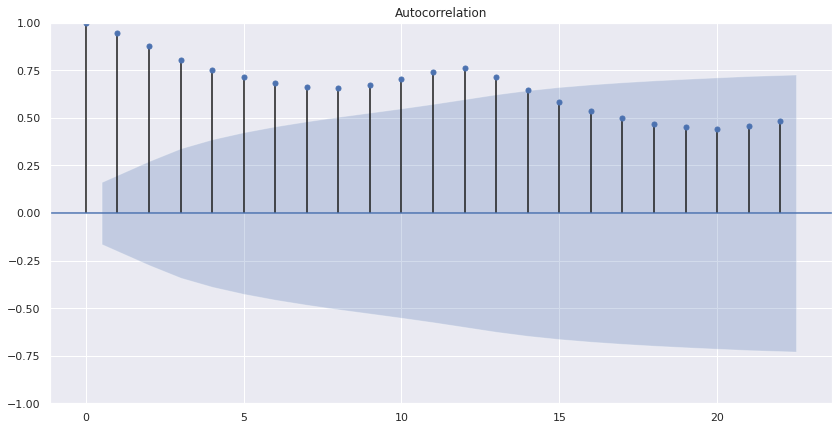

In [10]:
f.plot_acf()
plt.show()

In [ ]:
f.plot_pacf()
plt.show()

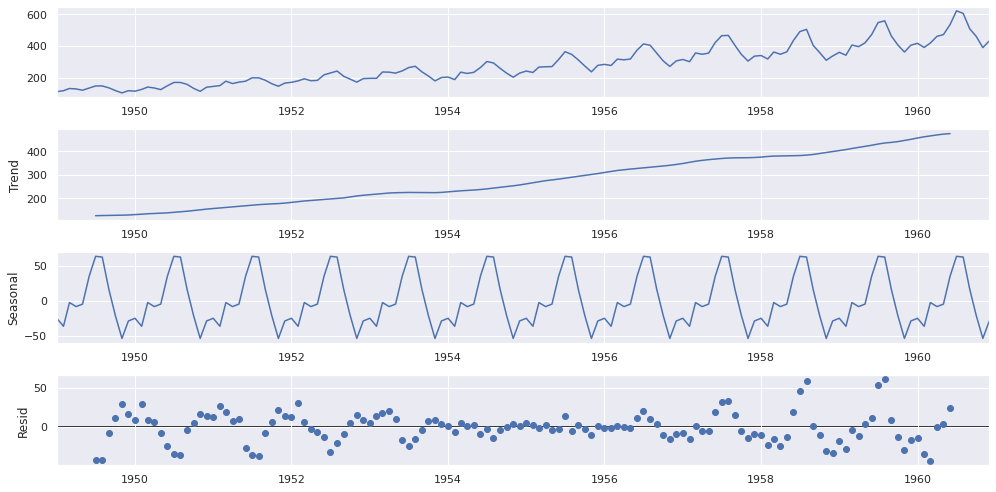

In [12]:
f.seasonal_decompose().plot()
plt.show()

In [13]:
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print(stat)
print(pval)

0.8153688792060472
0.991880243437641


In [14]:
f.manual_forecast(order=(1,1,1),seasonal_order=(2,1,1,12),call_me='arima2')

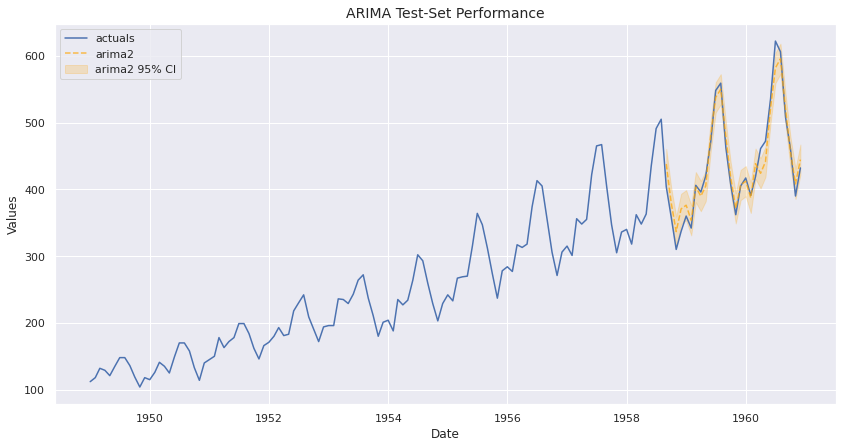

In [15]:
f.plot_test_set(ci=True,models='arima2')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

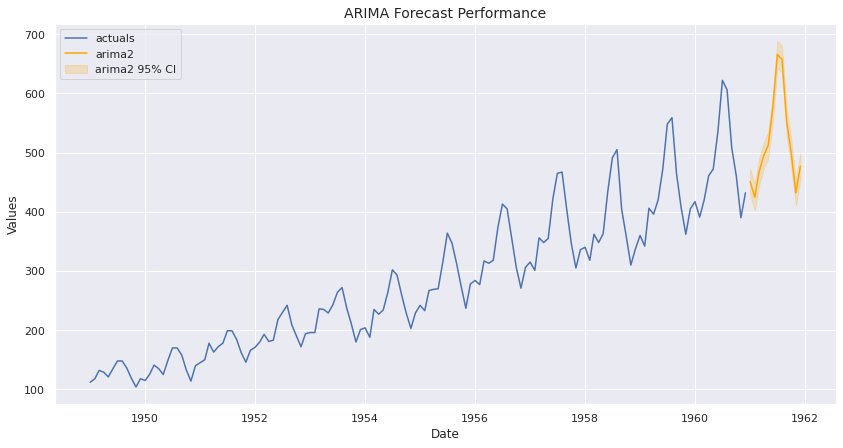

In [16]:
f.plot(ci=True,models='arima2')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

In [17]:
f.regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                  144
Model:             ARIMA(1, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -501.926
Date:                          Wed, 06 Jul 2022   AIC                           1015.853
Time:                                  01:02:24   BIC                           1033.104
Sample:                                       0   HQIC                          1022.862
                                          - 144                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0767      0.279     -0.275      0.783      -0.623       0.470
ma.L1         -0.3536      0.253     -1.399      0.162      -0.849       0.142
ar.S.L12       0.6681      0.154      4.326      0.000       0.365       0.971
ar.S.L24       0.3305      0.099      3.344      0.001       0.137       0.524
ma.S.L12      -0.9756      1.253     -0.779      0.436      -3.432       1.481
sigma2       110.5097    116.914      0.945      0.345    -118.637     339.656
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.84
Prob(Q):                              1.00   Prob(JB):                         0.02
Heteroskedasticity (H):               2.76   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Auto-ARIMA Approach

In [18]:
data = df.set_index('Month')
train = data.iloc[:int(.8*(df.shape[0])),:]
auto_model = auto_arima(train,start_P=1,start_q=1,max_p=6,max_q=6,m=12,seasonal=True,max_P=2, max_D=2,max_Q=2,
                            max_d=2,trace=True,error_action='ignore',suppress_warnings=True,stepwise=True,information_criterion="aic",alpha=0.05,scoring='mse')

best_params = auto_model.get_params()
order = best_params['order']
seasonal_order = best_params['seasonal_order']
trend = best_params['trend']

Performing stepwise search to minimize aic
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=760.183, Time=0.74 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=757.826, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=755.750, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=756.380, Time=0.18 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=755.499, Time=0.06 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=755.982, Time=0.17 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=757.649, Time=0.30 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=756.771, Time=0.07 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=756.022, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=756.011, Time=0.06 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=757.976, Time=0.12 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=757.438, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 2.067 seconds


In [19]:
f.manual_forecast(order=order,seasonal_order=seasonal_order,trend=trend,call_me='arima3')

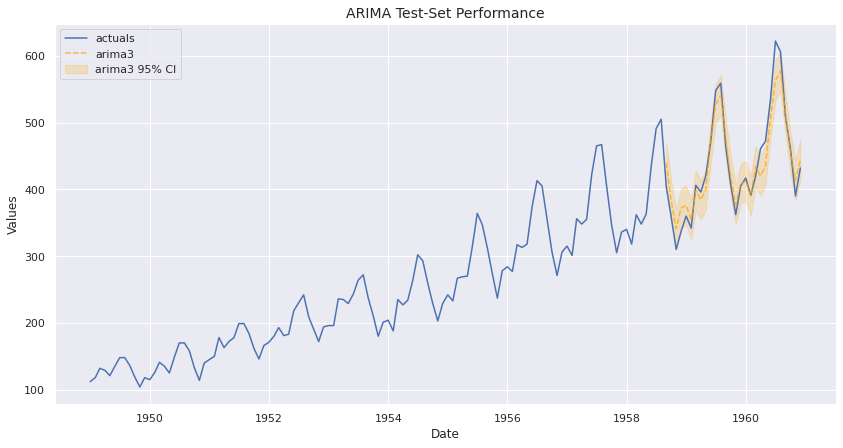

In [20]:
f.plot_test_set(ci=True,models='arima3')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

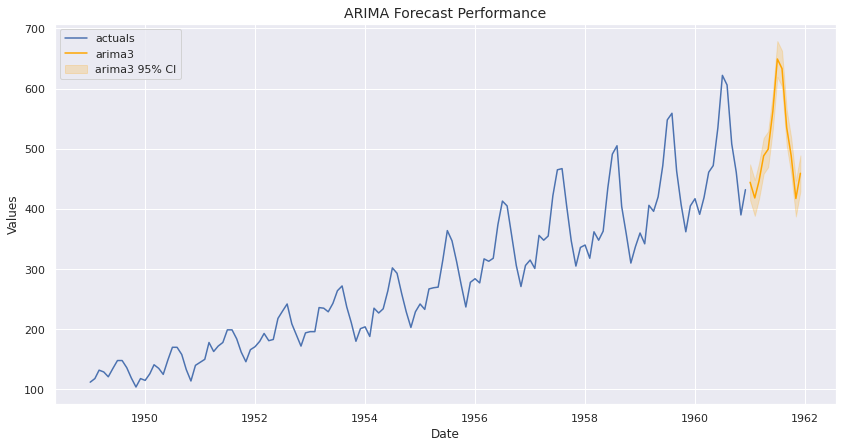

In [21]:
f.plot(ci=True,models='arima3')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

In [22]:
f.regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                  144
Model:             ARIMA(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -508.197
Date:                          Wed, 06 Jul 2022   AIC                           1020.393
Time:                                  01:02:52   BIC                           1026.144
Sample:                                       0   HQIC                          1022.730
                                          - 144                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3076      0.073     -4.186      0.000      -0.452      -0.164
sigma2       137.0108     14.623      9.370      0.000     108.351     165.670
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.75
Prob(Q):                              0.98   Prob(JB):                         0.02
Heteroskedasticity (H):               2.33   Skew:                             0.00
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Grid Search Approach

In [23]:
f.set_validation_length(12)
grid = {
    'order':[(1,1,1),(1,1,0),(0,1,1)],
    'seasonal_order':[(2,1,1,12),(1,1,1,12),(2,1,0,12),(0,1,0,12)]
}

f.ingest_grid(grid)
f.tune()
f.auto_forecast(call_me='arima4')

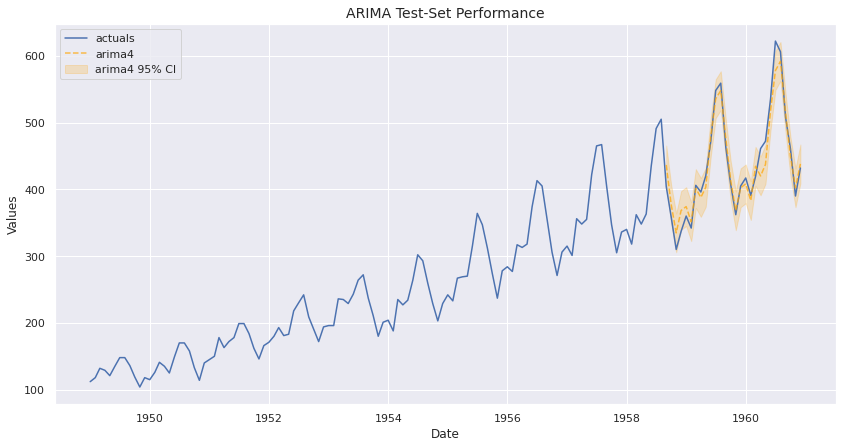

In [24]:
f.plot_test_set(ci=True,models='arima4')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

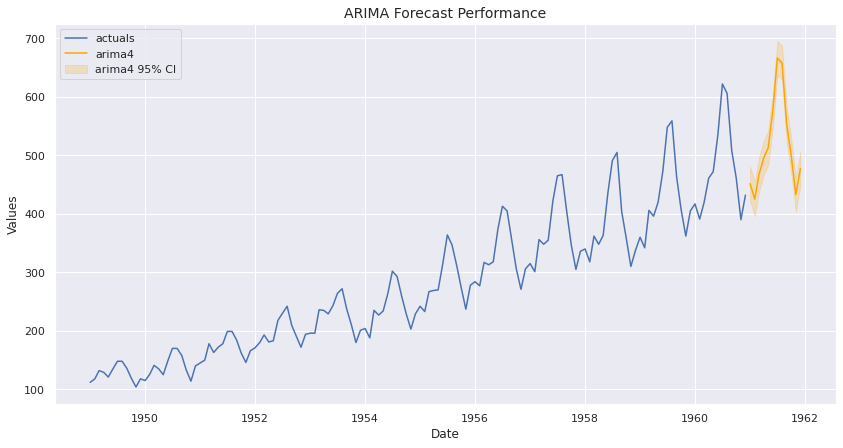

In [25]:
f.plot(ci=True,models='arima4')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

In [26]:
f.regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                  144
Model:             ARIMA(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -501.959
Date:                          Wed, 06 Jul 2022   AIC                           1013.917
Time:                                  01:04:04   BIC                           1028.293
Sample:                                       0   HQIC                          1019.759
                                          - 144                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4241      0.068     -6.198      0.000      -0.558      -0.290
ar.S.L12       0.6676      0.153      4.352      0.000       0.367       0.968
ar.S.L24       0.3311      0.096      3.435      0.001       0.142       0.520
ma.S.L12      -0.9760      1.279     -0.763      0.446      -3.484       1.532
sigma2       110.5428    119.575      0.924      0.355    -123.820     344.906
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 7.59
Prob(Q):                              0.91   Prob(JB):                         0.02
Heteroskedasticity (H):               2.80   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Export Results

In [27]:
pd.options.display.max_colwidth = 100
results = f.export(to_excel=True,excel_name='arima_results.xlsx',determine_best_by='TestSetMAPE')
summaries = results['model_summaries']
summaries[['ModelNickname','HyperParams','InSampleMAPE','TestSetMAPE']]

,ModelNickname,HyperParams,InSampleMAPE,TestSetMAPE
0,arima4,"{'order': (0, 1, 1), 'seasonal_order': (2, 1, 1, 12)}",0.044540,0.036373
1,arima2,"{'order': (1, 1, 1), 'seasonal_order': (2, 1, 1, 12)}",0.044446,0.037171
2,arima3,"{'order': (1, 1, 0), 'seasonal_order': (0, 1, 0, 12), 'trend': None}",0.046255,0.044223
3,arima1,{},0.442457,0.430066


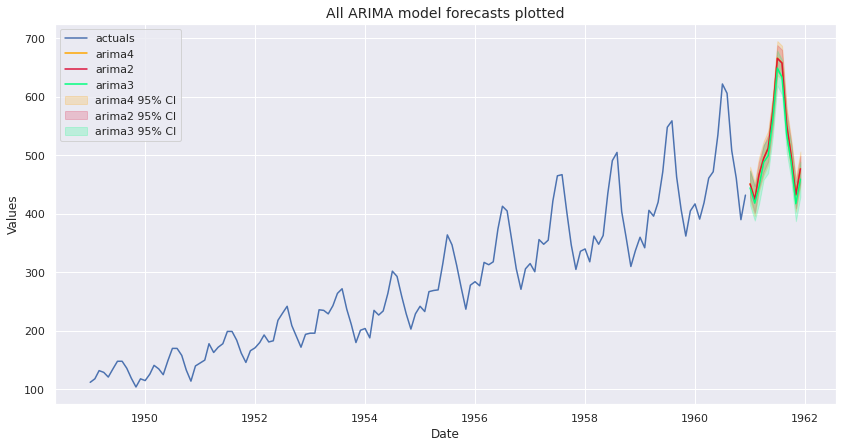

In [28]:
f.plot(ci=True,models=['arima2','arima3','arima4'],order_by='TestSetMAPE')
plt.title('All ARIMA model forecasts plotted',size=14)
plt.show()